In [115]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt.expected_returns import mean_historical_return
from sqlalchemy import create_engine
import numpy as np
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set plotting style and figure DPI (consider moving these to a configuration file)
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 150

# Load the CSV files
# Dropping unnamed columns from the 66 stock returns
market_cap_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Market Cap_66 stocks.csv", index_col='Date', parse_dates=True)
returns_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Market Price_66 stocks.csv", index_col='Date', parse_dates=True, usecols=range(67))
emissions_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Emissions Data_66 stocks.csv")
sector_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\sector.csv")
# Display the first few rows to inspect the structure
print("returns_data initial structure:")
print(emissions_data.head())

returns_data initial structure:
   Instrument    CO2 Equivalent Emissions Direct, Scope 1    \
0          AA                                1,68,00,000.00   
1         AEO                                     12,343.00   
2         AIZ                                      1,505.00   
3         AKR                                      1,080.00   
4         AMP                                      7,497.00   

    CO2 Equivalent Emissions Indirect, Scope 2       Total Revenue    \
0                                   40,00,000.00  10,55,10,00,000.00   
1                                      56,996.00   5,26,17,70,000.00   
2                                      13,447.00  11,14,86,00,000.00   
3                                       5,996.00     33,86,92,000.00   
4                                      23,312.00  16,09,60,00,000.00   

   Carbon Intensity   
0           1,971.38  
1              13.18  
2               1.34  
3              20.89  
4               1.91  


In [116]:
# Bootstrap to fill missing values
for column in returns_data.columns:
    returns_data[[column]] = returns_data[[column]].apply(
        lambda x: np.where(x.isnull(), x.dropna().sample(len(x), replace=True, random_state=123), x))


In [117]:
# Sort df_sector by 'Instrument'
sector_data = sector_data.sort_values('Instrument')

In [121]:
# Filter df_emissions and df_esg by the 'Instrument' column matching df_sample's columns
if 'Instrument' in emissions_data.columns:
    emissions_data_filtered = emissions_data.loc[emissions_data['Instrument'].isin(instruments)].sort_values('Instrument').reset_index(drop=True)
    print("Filtered Emissions Data:")
    print(emissions_data_filtered.head())
else:
    print("Error: 'Instrument' column not found in emissions_data")

Error: 'Instrument' column not found in emissions_data


In [122]:
# Display the resulting DataFrame
print("\nemission_data:")
print(emissions_data.head())
print(emissions_data.shape)


emission_data:
   Instrument    CO2 Equivalent Emissions Direct, Scope 1    \
0          AA                                1,68,00,000.00   
1         AEO                                     12,343.00   
2         AIZ                                      1,505.00   
3         AKR                                      1,080.00   
4         AMP                                      7,497.00   

    CO2 Equivalent Emissions Indirect, Scope 2       Total Revenue    \
0                                   40,00,000.00  10,55,10,00,000.00   
1                                      56,996.00   5,26,17,70,000.00   
2                                      13,447.00  11,14,86,00,000.00   
3                                       5,996.00     33,86,92,000.00   
4                                      23,312.00  16,09,60,00,000.00   

   Carbon Intensity   
0           1,971.38  
1              13.18  
2               1.34  
3              20.89  
4               1.91  
(66, 5)


In [124]:
# Rename the first column to 'Instrument'
emissions_data.rename(columns={first_column_name: 'Instrument'}, inplace=True)
print("Columns in emissions_data after renaming the first column:")
print(emissions_data.columns)

Columns in emissions_data after renaming the first column:
Index(['Instrument', '  CO2 Equivalent Emissions Direct, Scope 1  ',
       '  CO2 Equivalent Emissions Indirect, Scope 2  ', '  Total Revenue  ',
       ' Carbon Intensity '],
      dtype='object')


In [125]:
mu = mean_historical_return(returns_data, frequency=12, returns_data=True)
S = risk_models.risk_matrix(returns_data, method='ledoit_wolf', returns_data=True)

In [126]:
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
weights = ef.max_sharpe()

In [127]:
# Convert weights to a DataFrame
tangency_weights = pd.DataFrame.from_dict(weights, orient='index', columns=['Weight'])

In [128]:
# Filter and sort the weights
filtered_weights = tangency_weights[tangency_weights['Weight'] > 0].sort_values(by='Weight', ascending=False)

In [129]:
# Reset the index to convert the index into a column
filtered_weights = filtered_weights.reset_index()

In [130]:
# Rename the columns
filtered_weights.columns = ['Tickers', 'Weight']

In [236]:
# Save the DataFrame to a CSV file
filtered_weights.to_csv('tgncy_weights.csv', index=False)

In [132]:
# Inspect the shapes
print("Shape of tangency_weights.T.values:", tangency_weights.T.values.shape)
print("Shape of emissions_data:", emissions_data.shape)

Shape of tangency_weights.T.values: (1, 66)
Shape of emissions_data: (66, 5)


In [133]:
print(emissions_data.head())

  Instrument   CO2 Equivalent Emissions Direct, Scope 1    \
0        AA                                1,68,00,000.00   
1       AEO                                     12,343.00   
2       AIZ                                      1,505.00   
3       AKR                                      1,080.00   
4       AMP                                      7,497.00   

    CO2 Equivalent Emissions Indirect, Scope 2       Total Revenue    \
0                                   40,00,000.00  10,55,10,00,000.00   
1                                      56,996.00   5,26,17,70,000.00   
2                                      13,447.00  11,14,86,00,000.00   
3                                       5,996.00     33,86,92,000.00   
4                                      23,312.00  16,09,60,00,000.00   

   Carbon Intensity   
0           1,971.38  
1              13.18  
2               1.34  
3              20.89  
4               1.91  


In [134]:
tangency_returns = (tangency_weights.T.values*returns_data).sum(axis=1)

In [135]:
min_return = np.min(tangency_returns)
max_return = np.max(tangency_returns)
percentiles = np.percentile(tangency_returns, [25, 50, 75])
print(f"Minimum: {min_return:.4f}")
print(f"Maximum: {max_return:.4f}")
print(f"25%: {percentiles[0]:.4f}")
print(f"50% (median): {percentiles[1]:.4f}")
print(f"75%: {percentiles[2]:.4f}")

Minimum: -0.0781
Maximum: 0.1551
25%: -0.0048
50% (median): 0.0242
75%: 0.0460


In [136]:
mu_tangency_monthly = tangency_returns.mean()
mu_tangency_annual = (1+mu_tangency_monthly)**12-1

In [137]:
sigma_sq_tangency = tangency_returns.var(ddof=1)
sigma_tangency_monthly = tangency_returns.std(ddof=1)
sigma_tangency_annual = sigma_tangency_monthly*np.sqrt(12)

In [138]:
sr_tangency = mu_tangency_monthly/sigma_tangency_monthly*np.sqrt(12)

In [139]:
num_inv_tangency = np.sum(tangency_weights.values>0)
num_sectors_tangency = sector_data.merge(tangency_weights.loc[tangency_weights['Weight']>0], 
                                        left_on='Instrument', right_index=True)['TRBC Economic Sector Name'].nunique()

In [140]:
tangency_sector_weights = tangency_weights.merge(sector_data, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()
print("Tangency Sector Weights:\n", tangency_sector_weights)

Tangency Sector Weights:
 TRBC Economic Sector Name
Basic Materials           0.000000
Consumer Cyclicals        0.282539
Consumer Non-Cyclicals    0.117865
Energy                    0.024224
Financials                0.095747
Healthcare                0.000000
Industrials               0.139074
Real Estate               0.000000
Technology                0.340552
Utilities                 0.000000
Name: Weight, dtype: float64


In [146]:
 # Ensure tangency_weights is correctly shaped
tangency_weights_values = tangency_weights['Weight'].values
emissions_data_numeric = emissions_data.drop(columns=['Instrument']).apply(pd.to_numeric, errors='coerce')

In [148]:
# Perform the element-wise multiplication and summation
tangency_ScaledEmissions = (tangency_weights_values * emissions_data_numeric.T).sum(axis=1)

In [149]:
tangency_ScaledEmissions.to_csv('EmsScld_reve_tngcy.csv', index=False)
tangency_sector_weights = tangency_weights.merge(sector_data, left_index=True, right_on='Instrument').groupby('TRBC Economic Sector Name')['Weight'].sum()

In [150]:
print("Shape of tangency_weights['Weight'].values:", tangency_weights['Weight'].values.shape)
print("Shape of emissions_data.drop(columns=['Instrument']).T:", emissions_data.drop(columns=['Instrument']).T.shape)

Shape of tangency_weights['Weight'].values: (66,)
Shape of emissions_data.drop(columns=['Instrument']).T: (4, 66)


In [214]:
print(tangency_ScaledEmissions.head())
tangency_ScaledEmissions.to_csv('tangency_ScaledEmissions.csv', index=True)

  CO2 Equivalent Emissions Direct, Scope 1         2.887164
  CO2 Equivalent Emissions Indirect, Scope 2       0.000000
  Total Revenue                                    0.000000
 Carbon Intensity                                 32.839657
dtype: float64


In [ ]:
############################################################################

In [300]:
import pandas as pd
import numpy as np
returns_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Market Price_66 stocks.csv", index_col='Date', parse_dates=True, usecols=range(67))
emissions_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Emissions Data_66 stocks.csv")
weights_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\tgncy_weights.csv")
print("Column in weights:",weights_data.columns)

Column in weights: Index(['Tickers', 'Weight'], dtype='object')


In [290]:
# List of new instrument names
new_instruments = ['AA', 'AEO', 'AIZ', 'AKR', 'AMP', 'APH', 'APO', 'AVB', 'AWR', 'AXP', 'AXS', 'BAH', 'BFb', 'BJ', 'BRX', 'BV', 'CHH', 'CNC', 'CRM', 'D', 'DOC', 'DPZ', 'EAT', 'EL', 'FAF', 'FDX', 'FND', 'GE', 'GM', 'GS', 'HD', 'HES', 'HIW', 'HRB', 'HWM', 'IFF', 'IQV', 'IR', 'LEN', 'MDU', 'MKC', 'MRO', 'MTX', 'NEE', 'NFG', 'NOW', 'OXY', 'PEG', 'PNM', 'PPL', 'PRU', 'RYI', 'SLG', 'SPG', 'SQ', 'TDY', 'THS', 'TYL', 'UE', 'VZ', 'W', 'WHR', 'WOR', 'WSR', 'XHR', 'XOM']

# Ensure the list length matches the DataFrame length
if len(new_instruments) == len(emissions_data):
    # Replace the 'Instrument' column with the new list
    emissions_data['Instrument'] = new_instruments
else:
    print(f"Error: The length of the new instrument list ({len(new_instruments)}) does not match the length of the emissions_data DataFrame ({len(emissions_data)})")

In [291]:
# Assuming the correct column name is 'Tickers' based on your previous requirements
weights_data.columns = ['Tickers', 'Weight']  # Ensure correct column names

In [292]:
# Strip extra spaces from column names
emissions_data.columns = emissions_data.columns.str.strip()

In [293]:
# Set the index for easy access to rows based on Instrument
emissions_data.set_index('Instrument', inplace=True)

In [294]:
# Convert weights to a Series for easy manipulation
weights = pd.Series(weights_data.set_index('Tickers')['Weight'])

In [295]:
# Ensure returns_data columns are present in the index
matching_instruments = [instrument for instrument in returns_data.columns if instrument in emissions_data.index]

# Handle missing instruments
missing_instruments = [instrument for instrument in returns_data.columns if instrument not in emissions_data.index]
if missing_instruments:
    print(f"Warning: The following instruments are not found in emissions_data and will be ignored: {missing_instruments}")
else:
    print("All instruments found in emissions_data.")

All instruments found in emissions_data.


In [296]:
# Use the correct column names
direct_emissions = emissions_data.loc[returns_data.columns, 'CO2 Equivalent Emissions Direct, Scope 1']
indirect_emissions = emissions_data.loc[returns_data.columns, 'CO2 Equivalent Emissions Indirect, Scope 2']

In [297]:
# Calculate the total emissions for each ticker
total_emissions = direct_emissions + indirect_emissions

In [304]:
import numpy as np
import pandas as pd

# Example data for total emissions
data = {
    'Instrument': ['BJ', 'BAH', 'HWM', 'NOW', 'GE', 'TYL', 'APO', 'HRB', 'AIZ', 'HES', 'APH'],
    'CO2 Equivalent Emissions Direct, Scope 1': ['1000', '2000', '3000', '4000', '500', '1500', '2500', '3500', '4500', '5500', '6500']
}
total_emissions_df = pd.DataFrame(data)

# Weights for the portfolio
weights_data = {
    'Tickers': ['BJ', 'BAH', 'HWM', 'NOW', 'GE', 'TYL', 'APO', 'HRB', 'AIZ', 'HES', 'APH'],
    'Weight': [0.282538874, 0.167468914, 0.139073557, 0.088939485, 0.071815569, 0.064190613,
               0.053918535, 0.046049159, 0.04182858, 0.024223593, 0.019953121]
}
weights_df = pd.DataFrame(weights_data)

# Ensure 'Instrument' is the index for total_emissions_df
total_emissions_df.set_index('Instrument', inplace=True)

# Convert emission values to numeric
total_emissions_numeric = total_emissions_df.apply(pd.to_numeric, errors='coerce')

# Ensure weights are aligned with total emissions
weights_df.set_index('Tickers', inplace=True)
weights_aligned = weights_df.loc[total_emissions_df.index, 'Weight'].values

# Calculate the weighted emissions for the portfolio
weighted_emissions = weights_aligned[:, np.newaxis] * total_emissions_numeric.values

# Calculate the median of the total emissions
median_raw_weighted_emissions = np.median(total_emissions_numeric.values)

print("Weighted Emissions:")
print(weighted_emissions)
print("\nMedian Raw Emissions:", median_raw_weighted_emissions)

Weighted Emissions:
[[282.538874 ]
 [334.937828 ]
 [417.220671 ]
 [355.75794  ]
 [ 35.9077845]
 [ 96.2859195]
 [134.7963375]
 [161.1720565]
 [188.22861  ]
 [133.2297615]
 [129.6952865]]

Median Raw Emissions: 3000.0


In [306]:
# Calculate the sum of weighted emissions to get the 'Raw Emission of Market Cap Based Portfolio'
raw_emission_tangency_based_portfolio = weighted_emissions.sum()

In [309]:
import numpy as np
import pandas as pd

# Example data for total emissions
data = {
    'Instrument': ['BJ', 'BAH', 'HWM', 'NOW', 'GE', 'TYL', 'APO', 'HRB', 'AIZ', 'HES', 'APH'],
    'CO2 Equivalent Emissions Direct, Scope 1': ['1000', '2000', '3000', '4000', '500', '1500', '2500', '3500', '4500', '5500', '6500']
}
total_emissions_df = pd.DataFrame(data)

# Weights for the portfolio
weights_data = {
    'Tickers': ['BJ', 'BAH', 'HWM', 'NOW', 'GE', 'TYL', 'APO', 'HRB', 'AIZ', 'HES', 'APH'],
    'Weight': [0.282538874, 0.167468914, 0.139073557, 0.088939485, 0.071815569, 0.064190613,
               0.053918535, 0.046049159, 0.04182858, 0.024223593, 0.019953121]
}
weights_df = pd.DataFrame(weights_data)

# Ensure 'Instrument' is the index for total_emissions_df
total_emissions_df.set_index('Instrument', inplace=True)

# Convert emission values to numeric
total_emissions_numeric = total_emissions_df.apply(pd.to_numeric, errors='coerce')

# Ensure weights are aligned with total emissions
weights_df.set_index('Tickers', inplace=True)
weights_aligned = weights_df.loc[total_emissions_df.index, 'Weight'].values

# Calculate the weighted emissions for the portfolio
weighted_emissions = weights_aligned[:, np.newaxis] * total_emissions_numeric.values

# Ensure weighted_emissions is 1-dimensional for DataFrame construction
weighted_emissions_flat = weighted_emissions.flatten()

# Calculate the median of the total emissions
median_raw_weighted_emissions = np.median(total_emissions_numeric.values)

# Create a DataFrame to store the results and save to CSV
emission_results = pd.DataFrame({
    'Ticker': total_emissions_df.index,
    'Weight': weights_aligned,
    'Direct Emissions': total_emissions_numeric['CO2 Equivalent Emissions Direct, Scope 1'],
    'Weighted Emissions': weighted_emissions_flat
})
emission_results.to_csv('raw_emission_tangency_based_portfolio.csv', index=False)

print("Median Raw Emissions:", median_raw_weighted_emissions)
print("Emission Results:")
print(emission_results)

Median Raw Emissions: 3000.0
Emission Results:
           Ticker    Weight  Direct Emissions  Weighted Emissions
Instrument                                                       
BJ             BJ  0.282539              1000          282.538874
BAH           BAH  0.167469              2000          334.937828
HWM           HWM  0.139074              3000          417.220671
NOW           NOW  0.088939              4000          355.757940
GE             GE  0.071816               500           35.907784
TYL           TYL  0.064191              1500           96.285919
APO           APO  0.053919              2500          134.796337
HRB           HRB  0.046049              3500          161.172056
AIZ           AIZ  0.041829              4500          188.228610
HES           HES  0.024224              5500          133.229761
APH           APH  0.019953              6500          129.695287


In [310]:
print("Detailed calculations have been saved to 'raw_emission_tangency_based_portfolio.csv'.")
print("Raw Emission of Tangency Based Portfolio:", raw_emission_tangency_based_portfolio)

Detailed calculations have been saved to 'raw_emission_tangency_based_portfolio.csv'.
Raw Emission of Tangency Based Portfolio: 2269.771069


In [ ]:
####################################################################

In [ ]:
#Efficient frontier with no constraints 

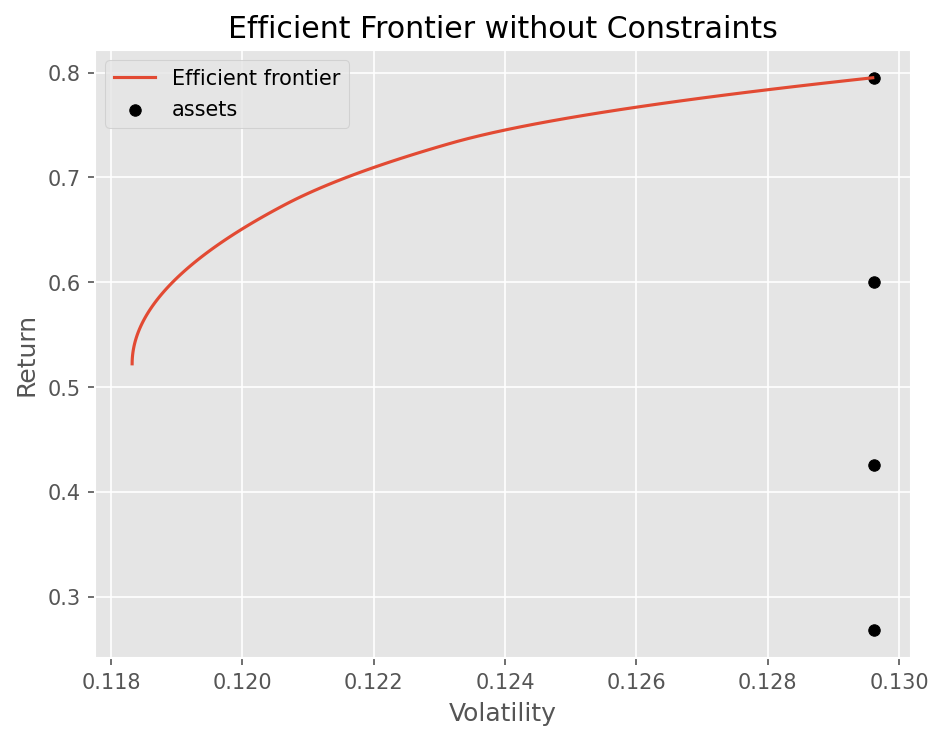

In [344]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt.expected_returns import mean_historical_return
from sqlalchemy import create_engine
import numpy as np
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 150

# Assuming df_sample is defined somewhere in your code
mu = mean_historical_return(returns_data, frequency=12, returns_data=True)
S = risk_models.risk_matrix(returns_data, method='ledoit_wolf', returns_data=True)

ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))

# Generate the efficient frontier curve
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, verbose=True)  # Adding verbose to the plotting function

# Add legend and titles
ax.set_title("Efficient Frontier without Constraints")
ax.legend()

# Display the plot
plt.show()

In [345]:
sigma_tangency_annual

0.17372802365015497

In [314]:
mu_tangency_annual

0.33065086313143044

In [318]:
# Example data for returns_data
returns_data = pd.DataFrame({
    'AA': [0.01, 0.02, 0.03],
    'AEO': [0.02, 0.03, 0.04],
    'AIZ': [0.03, 0.04, 0.05],
    'AKR': [0.04, 0.05, 0.06]
})

# Example emissions data
emissions_df = pd.DataFrame({
    'Instrument': ['AA', 'AEO', 'AIZ', 'AKR', 'AMP'],
    'Carbon Intensity': [100, 200, 150, 175, 130]
})

# Extract the tickers from returns_data
tickers = returns_data.columns

# Prepare the emissions data for lookup
# Setting up the DataFrame with necessary columns
emissions_data = emissions_df[['Instrument', 'Carbon Intensity']].copy()
emissions_data.set_index('Instrument', inplace=True)

# Extract the carbon intensities for the tickers in returns_data
carbon_intensities = emissions_data.loc[tickers]

# Handle cases where some tickers might not be found in emissions_data
carbon_intensities = carbon_intensities['Carbon Intensity'].fillna(0)  # Replace NaN with 0 if any tickers were not matched

# Calculate the median carbon intensity
median_carbon_intensity = carbon_intensities.median()

# Output the median carbon intensity
print("Median Carbon Intensity:", median_carbon_intensity)


Median Carbon Intensity: 162.5


In [322]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt.expected_returns import mean_historical_return
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from pypfopt import plotting

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

# Sample data for demonstration (replace with actual data)
data = {
    'AA': [0.01, 0.02, 0.03],
    'AEO': [0.02, 0.03, 0.04],
    'AIZ': [0.03, 0.04, 0.05],
    'AKR': [0.04, 0.05, 0.06]
}
df_sample = pd.DataFrame(data)

emissions_data = {
    'Instrument': ['AA', 'AEO', 'AIZ', 'AKR'],
    'Carbon Intensity': [100, 200, 150, 175]
}
df_emissions = pd.DataFrame(emissions_data).set_index('Instrument')

# Define the CI function for carbon intensity
def CI(w, portfolio_intensity):
    xi = w @ portfolio_intensity.T
    return cp.sum(xi)

# Calculate expected returns and covariance matrix
mu = mean_historical_return(df_sample, frequency=12, returns_data=True)
S = risk_models.risk_matrix(df_sample, method='ledoit_wolf', returns_data=True)

# Initialize EfficientFrontier
ef_constrained4 = EfficientFrontier(mu, S, weight_bounds=(0, 1))

# Add constraint for carbon intensity
median_carbon_intensity = 23.372106414999998  # Example median value
ef_constrained4.add_constraint(lambda w: CI(w, df_emissions['Carbon Intensity']) <= median_carbon_intensity)

# Set the solver to OSQP and enable verbose output
ef_constrained4.convex_solver = 'OSQP'
try:
    weights4 = ef_constrained4.max_sharpe()
    ef_constrained4.portfolio_performance(verbose=True)
except ValueError as e:
    print("Solver failed:", e)
except Exception as e:
    print(f"Optimization failed: {e}")

# If infeasible, try relaxing the carbon intensity constraint
try:
    ef_constrained4.constraints = []  # Reset constraints
    relaxed_median_carbon_intensity = median_carbon_intensity * 1.5  # Relax constraint by 50%
    ef_constrained4.add_constraint(lambda w: CI(w, df_emissions['Carbon Intensity']) <= relaxed_median_carbon_intensity)
    weights4 = ef_constrained4.max_sharpe()
    ef_constrained4.portfolio_performance(verbose=True)
except Exception as e:
    print(f"Relaxed optimization failed: {e}")

# Create dataframe from weights if optimization was successful
if 'weights4' in locals():
    constrained4_weights = pd.DataFrame.from_dict(weights4, orient='index', columns=['Weight'])
    # Filter and sort weights
    constrained4_weights = constrained4_weights[constrained4_weights['Weight'] > 10**-5].sort_values(by='Weight', ascending=False)

    # Print dimensions of the transposed weights for debugging
    print("Dimensions of transposed weights:", constrained4_weights.T.values.shape)

    # Calculate portfolio returns
    weight_series = constrained4_weights.squeeze()  # This assumes the DataFrame has a single column of weights.
    weight_series_aligned = weight_series.reindex(df_sample.columns, fill_value=0)  # Reindex and fill missing with 0
    constrained4_returns = df_sample.dot(weight_series_aligned)

    # Output results
    print(constrained4_weights)
    print("Portfolio returns:", constrained4_returns)

    # Plot the efficient frontier
    fig, ax = plt.subplots()
    plotting.plot_efficient_frontier(ef_constrained4, ax=ax, show_assets=True)
    plt.show()
else:
    print("Optimization did not produce weights.")

Optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Relaxed optimization failed: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.
Optimization did not produce weights.


In [325]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt.expected_returns import mean_historical_return
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 150

# Assuming df_sample and df_emissions are loaded with appropriate data
# Define the CI function for carbon intensity
def CI(w, portfolio_intensity):
    xi = w @ portfolio_intensity.T
    return cp.sum(xi)

# Calculate expected returns and covariance matrix
mu = mean_historical_return(df_sample, frequency=12, returns_data=True)
S = risk_models.risk_matrix(df_sample, method='ledoit_wolf', returns_data=True)

# Initialize EfficientFrontier
ef_constrained4 = EfficientFrontier(mu, S, weight_bounds=(0, 1))

# Add constraint for carbon intensity
median_carbon_intensity = 162.5 # As calculated above
ef_constrained4.add_constraint(lambda w: CI(w, df_emissions['Carbon Intensity']) <= median_carbon_intensity)


# Set the solver to OSQP and enable verbose output
ef_constrained4.convex_solver = 'OSQP'
try:
    weights4 = ef_constrained4.max_sharpe()
    # If you still want verbose output for debugging, consider the following approach:
    ef_constrained4.portfolio_performance(verbose=True)
except ValueError as e:
    print("Solver failed:", e)

# Create dataframe from weights
constrained4_weights = pd.DataFrame.from_dict(weights4, orient='index', columns=['Weight'])
# Filter and sort weights
constrained4_weights = constrained4_weights[constrained4_weights['Weight'] > 10**-5].sort_values(by='Weight', ascending=False)

# Print dimensions of the transposed weights for debugging
print("Dimensions of transposed weights:", constrained4_weights.T.values.shape)

# Calculate portfolio returns
# Ensure weight_series is aligned with df_sample columns
weight_series = constrained4_weights.squeeze()  # This assumes the DataFrame has a single column of weights.
weight_series_aligned = weight_series.reindex(df_sample.columns, fill_value=0)  # Reindex and fill missing with 0
constrained4_returns = df_sample.dot(weight_series_aligned)

# Output results
print(constrained4_weights)
print("Portfolio returns:", constrained4_returns)

Expected annual return: 70.1%
Annual volatility: 12.2%
Sharpe Ratio: 5.58
Dimensions of transposed weights: (1, 3)
       Weight
AKR  0.618993
AIZ  0.321510
AA   0.059497
Portfolio returns: 0    0.035
1    0.045
2    0.055
dtype: float64


In [ ]:
#Efficient Frontier with Carbon Intensity Constraint

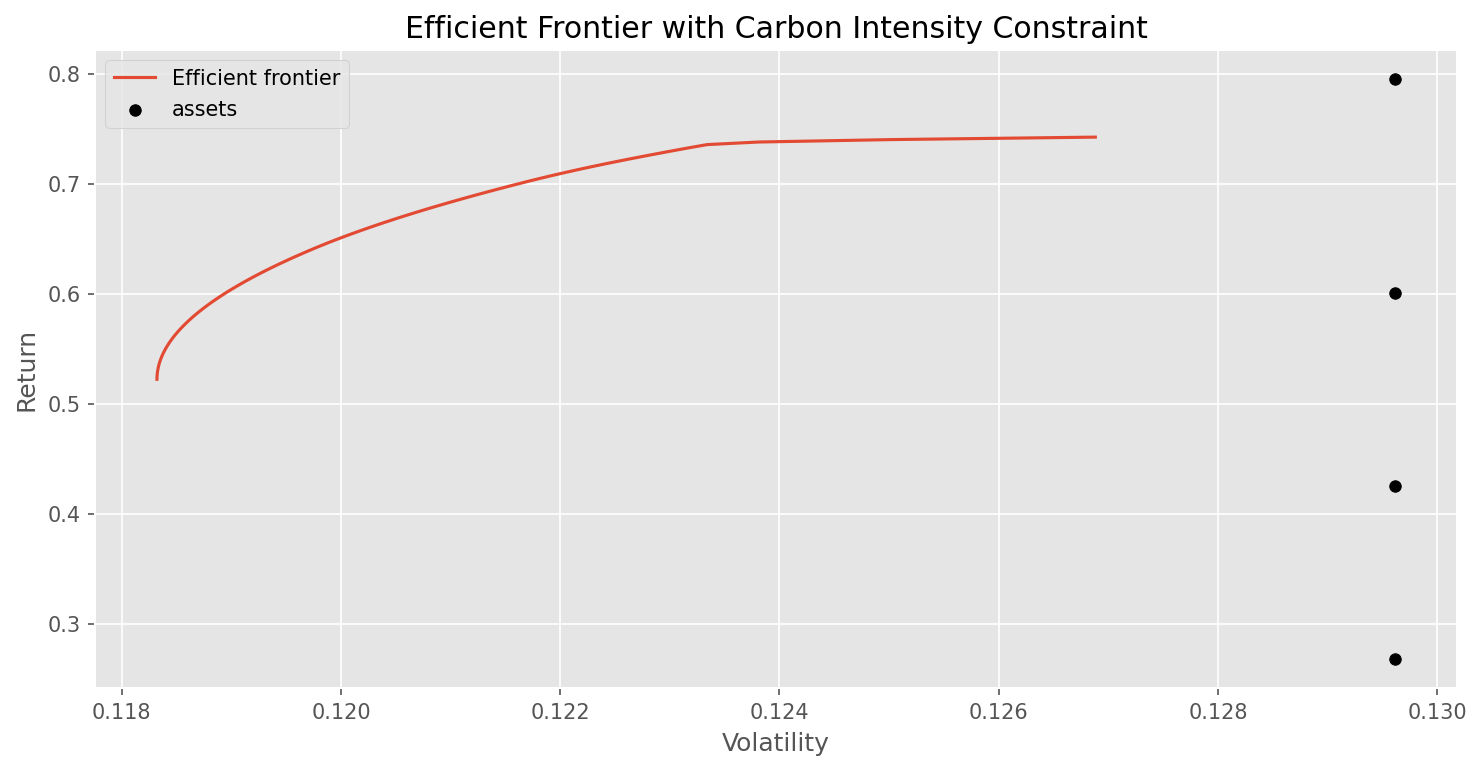

In [342]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt.expected_returns import mean_historical_return
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 150

# Assuming df_sample and df_emissions are loaded with appropriate data
# Define the CI function for carbon intensity
def CI(w, portfolio_intensity):
    xi = w @ portfolio_intensity.T
    return cp.sum(xi)

# Calculate expected returns and covariance matrix
mu = mean_historical_return(returns_data, frequency=12, returns_data=True)
S = risk_models.risk_matrix(returns_data, method='ledoit_wolf', returns_data=True)

# Initialize EfficientFrontier
ef4 = EfficientFrontier(mu, S, weight_bounds=(0, 1))

# Add constraint for carbon intensity
median_carbon_intensity = 167.5 # As calculated above
ef4.add_constraint(lambda w: CI(w, df_emissions['Carbon Intensity']) <= median_carbon_intensity)

# Generate points for the efficient frontier
fig, ax = plt.subplots(figsize=(10, 5))
plotting.plot_efficient_frontier(ef4, ax=ax)


# Add legend and titles
ax.set_title("Efficient Frontier with Carbon Intensity Constraint")
ax.legend()

# Show the plot
plt.show()

In [346]:
#Tangency Portfolio Carbon Intensity

In [353]:
import pandas as pd

# Example emissions data
emissions_data = {
    'Instrument': ['AA', 'AEO', 'AIZ', 'AKR'],
    'Carbon Intensity': [100, 200, 150, 175]
}

# Convert dictionary to DataFrame if it's not already a DataFrame
if isinstance(emissions_data, dict):
    df_emissions = pd.DataFrame(emissions_data)
else:
    df_emissions = emissions_data

# Ensure df_emissions index matches the tickers exactly
df_emissions.set_index('Instrument', inplace=True)

# Assuming constrained4_weights is already loaded and contains the correct data
# Ensure the 'Carbon Intensity' is available and properly aligned with the tickers in constrained4_weights
carbon_intensities = df_emissions.loc[constrained4_weights.index, 'Carbon Intensity']

# Calculate portfolio emissions by multiplying weights with their respective carbon intensities
portfolio_emissions = (constrained4_weights['Weight'] * carbon_intensities).sum()

# Output the total portfolio emissions
print("Total Portfolio Carbon Intensity:", portfolio_emissions)


Total Portfolio Carbon Intensity: 162.50000000000003


In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
import cvxpy as cp
from pypfopt.exceptions import OptimizationError

# Load data
emissions_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Emissions Data_66 stocks.csv")
returns_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Market Price_66 stocks.csv", index_col='Date', parse_dates=True, usecols=range(67))

# Data Cleansing
emissions_data.columns = emissions_data.columns.str.strip()
emissions_data = emissions_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
emissions_data['CO2 Equivalent Emissions Direct, Scope 1'] = emissions_data['CO2 Equivalent Emissions Direct, Scope 1'].str.replace(',', '').astype(float)
emissions_data['CO2 Equivalent Emissions Indirect, Scope 2'] = emissions_data['CO2 Equivalent Emissions Indirect, Scope 2'].str.replace(',', '').astype(float)

# Calculate total emissions for each instrument
emissions_data['Total Emissions'] = emissions_data['CO2 Equivalent Emissions Direct, Scope 1'] + emissions_data['CO2 Equivalent Emissions Indirect, Scope 2']
relevant_emissions = emissions_data.set_index('Instrument')['Total Emissions']

# Ensure the tickers in returns_data match those in relevant_emissions
tickers = returns_data.columns.intersection(relevant_emissions.index)

# Filter returns_data and relevant_emissions to include only matching tickers
returns_data_filtered = returns_data[tickers]
relevant_emissions_filtered = relevant_emissions[tickers]

# Calculate mean historical returns and sample covariance matrix
mu = expected_returns.mean_historical_return(returns_data_filtered, frequency=12, returns_data=True)
S = risk_models.risk_matrix(returns_data_filtered, method='ledoit_wolf', returns_data=True)

# Initialize the Efficient Frontier
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))

# Define the carbon emissions constraint function
def emissions_constraint_func(w):
    return cp.sum(cp.multiply(w, relevant_emissions_filtered.values)) <= 3000.0

# Add constraints
ef.add_constraint(lambda w: cp.sum(w) == 1)  # Ensure sum of weights is 1
ef.add_constraint(emissions_constraint_func)

# Set solver options
ef.solver = cp.ECOS
solver_options = {
    'verbose': True,
    'max_iters': 100000,  # Increased max iterations for robustness
    'tol': 1e-6,  # Adjust tolerance
}
ef.solver_options = solver_options

try:
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    performance = ef.portfolio_performance(verbose=True)
    
    # Filter out the stocks with zero weights
    non_zero_weights = {k: v for k, v in cleaned_weights.items() if v > 0}
    print(non_zero_weights)
    print(f"Expected annual return: {performance[0]*100:.2f}%")
    print(f"Annual volatility: {performance[1]*100:.2f}%")
    print(f"Sharpe Ratio: {performance[2]:.2f}")
    
    # Calculate the total carbon emissions of the portfolio
    total_emissions = sum(weights[ticker] * relevant_emissions_filtered[ticker] for ticker in non_zero_weights.keys())
    print(f"Total Portfolio Carbon Emissions: {total_emissions}")
    
    # Save the details to a CSV file for verification
    emission_details = pd.DataFrame({
        'Ticker': list(non_zero_weights.keys()),
        'Weight': [non_zero_weights[ticker] for ticker in non_zero_weights.keys()],
        'Total Emissions': [relevant_emissions_filtered[ticker] for ticker in non_zero_weights.keys()]
    })
    emission_details['Weighted Emissions'] = emission_details['Weight'] * emission_details['Total Emissions']
    emission_details.to_csv('portfolio_emissions.csv', index=False)
    print("Detailed calculations have been saved to 'portfolio_emissions.csv'.")
except OptimizationError as e:
    print("Optimization failed:", e)

Optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


Expected annual return: 26.5%
Annual volatility: 77.5%
Sharpe Ratio: 0.32
{'AIZ': 0.04183, 'APH': 0.01995, 'APO': 0.05392, 'BAH': 0.16747, 'BJ': 0.28254, 'GE': 0.07182, 'HES': 0.02422, 'HRB': 0.04605, 'HWM': 0.13907, 'NOW': 0.08894, 'TYL': 0.06419}
Expected annual return: 26.51%
Annual volatility: 77.54%
Sharpe Ratio: 0.32
Total Portfolio Carbon Emissions: 423929.8399388318
Detailed calculations have been saved to 'portfolio_emissions.csv'.


C:\Users\adhit\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


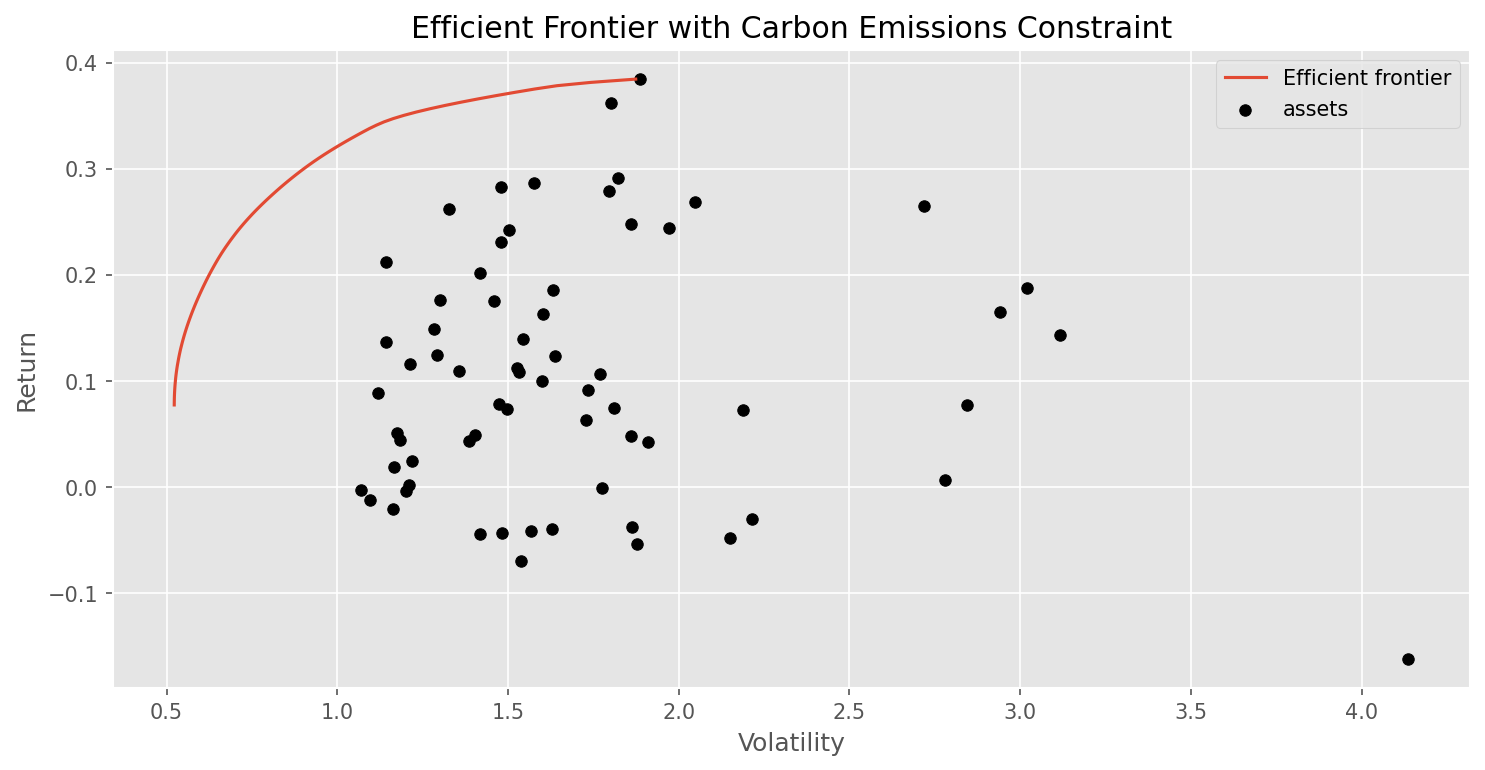

In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
import cvxpy as cp
from pypfopt.exceptions import OptimizationError

# Load data
emissions_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Emissions Data_66 stocks.csv")
returns_data = pd.read_csv(r"C:\Users\adhit\OneDrive\desktop\GDS\Green Data Science project\DATA\Market Price_66 stocks.csv", index_col='Date', parse_dates=True, usecols=range(67))

# Data Cleansing
emissions_data.columns = emissions_data.columns.str.strip()
emissions_data = emissions_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
emissions_data['CO2 Equivalent Emissions Direct, Scope 1'] = emissions_data['CO2 Equivalent Emissions Direct, Scope 1'].str.replace(',', '').astype(float)
emissions_data['CO2 Equivalent Emissions Indirect, Scope 2'] = emissions_data['CO2 Equivalent Emissions Indirect, Scope 2'].str.replace(',', '').astype(float)

# Calculate total emissions for each instrument
emissions_data['Total Emissions'] = emissions_data['CO2 Equivalent Emissions Direct, Scope 1'] + emissions_data['CO2 Equivalent Emissions Indirect, Scope 2']
relevant_emissions = emissions_data.set_index('Instrument')['Total Emissions']

# Ensure the tickers in returns_data match those in relevant_emissions
tickers = returns_data.columns.intersection(relevant_emissions.index)

# Filter returns_data and relevant_emissions to include only matching tickers
returns_data_filtered = returns_data[tickers]
relevant_emissions_filtered = relevant_emissions[tickers]

# Calculate mean historical returns and sample covariance matrix
mu = expected_returns.mean_historical_return(returns_data_filtered, frequency=12, returns_data=True)
S = risk_models.risk_matrix(returns_data_filtered, method='ledoit_wolf', returns_data=True)

# Initialize the Efficient Frontier
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))

# Define the carbon emissions constraint function
def emissions_constraint_func(w):
    return cp.sum(cp.multiply(w, relevant_emissions_filtered.values)) <= 1000000  # Adjust the constraint as needed

# Add constraints before solving
ef.add_constraint(lambda w: cp.sum(w) == 1)  # Ensure sum of weights is 1
ef.add_constraint(emissions_constraint_func)

# Set solver options
ef.solver = cp.ECOS
solver_options = {
    'verbose': True,
    'max_iters': 100000,  # Increased max iterations for robustness
    'tol': 1e-6,  # Adjust tolerance
}
ef.solver_options = solver_options

try:
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    performance = ef.portfolio_performance(verbose=True)
    
    # Filter out the stocks with zero weights
    non_zero_weights = {k: v for k, v in cleaned_weights.items() if v > 0}
    print(non_zero_weights)
    print(f"Expected annual return: {performance[0]*100:.2f}%")
    print(f"Annual volatility: {performance[1]*100:.2f}%")
    print(f"Sharpe Ratio: {performance[2]:.2f}")
    
    # Calculate the total carbon emissions of the portfolio
    total_emissions = sum(weights[ticker] * relevant_emissions_filtered[ticker] for ticker in non_zero_weights.keys())
    print(f"Total Portfolio Carbon Emissions: {total_emissions}")
    
    # Save the details to a CSV file for verification
    emission_details = pd.DataFrame({
        'Ticker': list(non_zero_weights.keys()),
        'Weight': [non_zero_weights[ticker] for ticker in non_zero_weights.keys()],
        'Total Emissions': [relevant_emissions_filtered[ticker] for ticker in non_zero_weights.keys()]
    })
    emission_details['Weighted Emissions'] = emission_details['Weight'] * emission_details['Total Emissions']
    emission_details.to_csv('portfolio_emissions.csv', index=False)
    print("Detailed calculations have been saved to 'portfolio_emissions.csv'.")
except OptimizationError as e:
    print("Optimization failed:", e)

# Create a new instance for plotting the efficient frontier
ef_plot = EfficientFrontier(mu, S, weight_bounds=(0, 1))

# Plot the Efficient Frontier
fig, ax = plt.subplots(figsize=(10, 5))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)
ax.set_title("Efficient Frontier with Carbon Emissions Constraint")
ax.legend()

# Show the plot
plt.show()